In [1]:
%load_ext autoreload
%autoreload 2

#%config IPCompleter.greedy=True

# Rotation curves

First, imports:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy import units
from pathlib import Path
import os
import astropy.units as u
from astropy.constants import G

import snapshot_obj 
import curve_fit
import dataset_compute

import importlib

In [3]:
importlib.reload(snapshot_obj)
importlib.reload(curve_fit)
importlib.reload(dataset_compute)

<module 'dataset_compute' from '/home/kassiili/Curvaton_Simulations/analysis/dataset_compute.py'>

## Get data

In [4]:
# Which halo:
gn = 1; sgn = 0

# Get LCDM data:
LCDM = snapshot_obj.Snapshot("CDM_V1_LR",127)

In [5]:
# Read halo:
fnum = LCDM.file_of_halo(gn,sgn)
SGNs = LCDM.get_subhalos("SubGroupNumber",fnums=[fnum])
GNs = LCDM.get_subhalos("GroupNumber",fnums=[fnum])

vmax = LCDM.get_subhalos("Vmax",fnums=[fnum]) / 100000 
                                                    # cm/s to km/s 
rmax = LCDM.get_subhalos("VmaxRadius",fnums=[fnum]) \
            * u.cm.to(u.kpc)

# Select halo:
halo_mask = np.logical_and(SGNs == sgn,GNs == gn)
vmax = vmax[halo_mask]
rmax = rmax[halo_mask]

In [6]:
# V1kpc:
SGNs = LCDM.get_subhalos("SubGroupNumber")
GNs = LCDM.get_subhalos( "GroupNumber")
halo_mask = np.logical_and(SGNs == sgn,GNs == gn)
v1kpc = LCDM.get_subhalos("V1kpc") 
v1kpc = v1kpc[halo_mask]

In [7]:
# Rotation curve:
r, v_circ = dataset_compute.compute_rotation_curve(LCDM, gn, sgn)
r = r * u.cm.to(u.kpc)
v_circ = v_circ * u.cm.to(u.km)

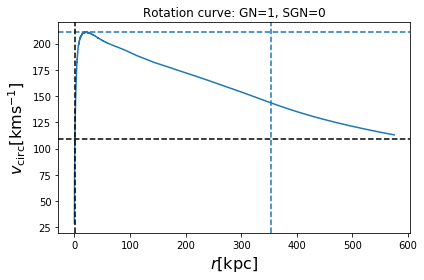

In [8]:
fig, axes = plt.subplots()

# Set axes:
#axes.set_xscale('log')
#axes.set_yscale('log')
#axes.set_xlim(x_down,x_up)
#axes.set_ylim(y_down,y_up)

# Set labels:
axes.set_xlabel('$r[\mathrm{kpc}]$', fontsize=16)
axes.set_ylabel('$v_{\mathrm{circ}}[\mathrm{kms^{-1}}]$', fontsize=16)

# Galaxy text:
axes.set_title('Rotation curve: GN={}, SGN={}'.format(gn,sgn))

axes.plot(r, v_circ)
axes.axhline(vmax,linestyle='dashed')
axes.axvline(rmax,linestyle='dashed')
axes.axhline(v1kpc,linestyle='dashed',c='black')
axes.axvline(1,linestyle='dashed',c='black')
    
#plt.legend()
plt.tight_layout()


# Save figure:
#
#filename = 'cumulDistByVmax_evol_{}.png'.format(galaxy)
#
#home = os.path.dirname(snapshot_obj.__file__)
#path = os.path.join(home,"Figures")
#
## If the directory does not exist, create it
#if not os.path.exists(path):
#    os.makedirs(path)
#plt.savefig(os.path.join(path,filename), dpi=200)